In [154]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt, ceil
import csv

def getOffsets(A, option): #normalizing an array
    
    _,m=A.shape
    
    #lower and upper bounds joint angles
    lb_theta = np.array([0,-30,-30,-180,-90,-180])*np.pi/180;   
    ub_theta = np.array([90,60,30,180,90,180])*np.pi/180;     
    df_theta = ub_theta-lb_theta
    
    #lower and upper bounds force
    lb_force = np.array([-2000,-2000,-2000,0,0,0]); ub_force = np.array([2000,2000,2000,0,0,0]); df_force=ub_force-lb_force
    
    #lower and upper bounds of absolute pose xyz coordinates
    lb_pose = np.array([-1,-1,-1]); ub_pose = np.array([3,3,3]); df_pose=ub_pose-lb_pose          
    
    #lower and upper bounds of quaternions
    lb_quat=np.array([-1,-1,-1,-1]); ub_quat=np.array([1,1,1,1]); df_quat=ub_quat-lb_quat
    
    # relative pose and angular error shall not be normalized
    offset_z = np.array([0,0,0]); length_z=np.array([1,1,1])
    
    if (option=="minmax"):
        offset=[np.min(A[:,i:i+1]) for i in range(m)]
        length=[np.max(A[:,i:i+1])-np.min(A[:,i:i+1]) for i in range(m)]
    
    elif(option=="standard"):
        offset=[np.mean(A[:,i:i+1]) for i in range(m)]
        length=[np.std(A[:,i:i+1]) for i in range(m)]        
    
    elif(option=="dataset1"): #dataset 1 
        # input (6): six joint angles (rad); 
        # output (7): absolute pose xyz, i.e. position (m) and quaternions
        offset=np.concatenate((lb_theta, lb_pose,lb_quat))
        length=np.concatenate((df_theta, df_pose, df_quat))
    
    elif(option=="dataset2"): #dataset 2 
        # input (12): six joint angles (rad), wrench vector (force(N), torque(Nm)=zeros)
        # output (7): absolute pose, i.e. position (m) and quaternions
        offset = np.concatenate((lb_theta, lb_force, lb_pose, lb_quat))
        length = np.concatenate((df_theta, df_force, df_pose, df_quat))        

    elif(option=="dataset3"): #dataset 3 
        # input (12): six joint angles (rad), wrench vector (force(N), torque(Nm)=zeros)
        # output (7): relative pose, i.e. position error (m) and quaternion error
        offset = np.concatenate((lb_theta, lb_force, offset_z, lb_quat))
        length = np.concatenate((df_theta, df_force, length_z, df_quat))                
        
    elif(option=="dataset4"): #dataset 4 
        # input (6): six joint angles (rad)
        # intput (7): absolute pose, i.e. position (m) and quaternions
        offset = np.concatenate((lb_theta, lb_pose, lb_quat))
        length = np.concatenate((df_theta, df_pose, df_quat))            
        
    elif(option=="dataset5"): #dataset 5 
        # input (6): six joint angles (rad)
        # output (6): relative pose, i.e. position error (m) and angular error (rad)
        offset = np.concatenate((lb_theta, offset_z, offset_z))
        length = np.concatenate((df_theta, length_z, length_z))

    elif(option=="dataset6"): #dataset 6 
        # input (9): six joint angles (rad), force vector (N)
        # output (6): absolute pose, i.e. position (m) and angular error (rad)
        offset=np.concatenate((lb_theta, lb_force[:3],lb_pose,offset_z))
        length=np.concatenate((df_theta, df_force[:3],df_pose,length_z))        
    
    elif(option=="none"): #no normalization
        offset=np.zeros(m)
        length=np.zeros(m)
        
    else:
        print("Error: unknown option for normalization")                
        raise Exception("")
        
    return(offset,length)


def normalize(A,offset,length):
    _,m=A.shape
    for i in range(m):
        if(length[i]!=0):
            A[:,i:i+1] = (A[:,i:i+1]-offset[i])/length[i]        

        
def denormalize(A,offset,length): #normalizing an array
    _,m=A.shape
    for i in range(m):
        if(length[i]!=0):
            A[:,i:i+1] = A[:,i:i+1]*length[i] + offset[i]
    


In [2]:
def test(fn="dataset5"):
    dataframe = np.loadtxt("datasets/"+fn+".csv",delimiter=",")
    m,N=dataframe.shape
    
    #normalization
    offset, length = getOffsets(dataframe,fn)
    inputs=6

    normalize(dataframe, offset,length)
    
    #data splitting
    
    data = dataframe[:,:inputs]
    labels= dataframe[:,inputs:]
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2,shuffle=True)

# random_state=42
    #create model
    model=ELM_model(data_train,labels_train,252,distribution="normal",activation="sigmoid")

    print(model.analyse_mean_error_XYZ(data_train,labels_train,offset,length))
    print(model.analyse_mean_error_XYZ(data_test,labels_test,offset,length))    

    return(model, data_test,labels_test)
    
#    model.print_prediction(data_train,labels_train,offset,length,xlim=0.2)
    
#    print(model.analyse_mean_error_XYZ(data_test[10:11],labels_test[10:11],offset,length))
#    model.learnBatch(data_test,labels_test,offset,length)
#    model.print_prediction(data_train,labels_train,offset,length,xlim=0.2)
#learnBatch(model,data_train,labels_train,offset,length)
#learnBatch(model,data,labels,offset,length)
#print(model.analyse_mean_error_XYZ(data,labels,offset,length))



In [3]:
    
def error_prediction(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand",xlim=10,n_bins=400):
    dataframe = np.loadtxt(filename,delimiter=",")
    m,N=dataframe.shape
    
    #normalization
    offset, length = getOffsets(dataframe, normalization)
    
    normalize(dataframe,offset,length)
    
    #data splitting
    data = dataframe[:,:inputs]
    labels= dataframe[:,inputs:]
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, random_state=42)

    #create model
    model=ELM_model(data_train,labels_train,neurons,activation,distribution)

    #predict
    prediction=model.predict(data_test)

    #denormalization    
    denormalize(prediction, offset, length)
    denormalize(labels_test, offset, length)

    diff=prediction-labels_test
    
    normalize(labels_test,offset,length)
    return(diff)

def print_prediction(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand", xlim=10,n_bins=400):
    
    diff = error_prediction(filename, inputs, normalization, neurons, activation,distribution,xlim,n_bins)                                   
    
    # Convert from m in mm
    diff=diff*1000
    
    figure,axis=plt.subplots(1,3)
    figure.set_figwidth(50)
    figure.set_figheight(20)        
    maximum={}
    mean={}
    stderiv={}
    XLabels=["X error in mm", "Y error in mm", "Z error in mm"]    
    for i in range(3):        
        maximum[i]=np.max(abs(diff[:,i:i+1]))
        mean[i]=np.mean(diff[:,i:i+1])
        stderiv[i]=np.std(diff[:,i:i+1])
        axis[i].hist(abs(diff[:,i:i+1]),n_bins)
        axis[i].set_xlim(0,xlim)        
        axis[i].set_xlabel(XLabels[i])        
    plt.show()     
    label=["X","Y","Z"]
    print('{:<25}{:^25}{:>25}'.format("Maximum","Mean","StDerv"))
    print('{:<25}{:^25}{:>25}'.format("-----","-----","-----"))    
    for i in range(3):
        print(label[i],'{:<25}{:^25}{:>25}'.format(str(maximum[i]),str(mean[i]),str(stderiv[i])))
        
    absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
    print("Average absolute positional error in mm: ", np.average(absolute))

def loss(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand",xlim=10,n_bins=400):
    diff = error_prediction(filename, inputs, normalization, neurons, activation,distribution,xlim,n_bins)*1000
    absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
    return(np.mean(absolute))



In [270]:
%reset_selective -f [model, x ,y]
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt, ceil
import csv

SMALLEST = np.nextafter(0, 1)

class ELM_model:
    
    def __init__(self,data,labels,hidden_size,activation="relu",distribution="rand",norandom=False):
        self.data = data
        self.labels = labels
        self.hidden_size=hidden_size
        if(activation=="relu"):
            self.activation=self.relu
        elif(activation=="sigmoid"):
            self.activation=self.sigmoid
        else:
            print("Error: no such activation rule implemented")
            return()
        
        # set input nodes randomly either using rand or normal distribution
        _, input_size = self.data.shape
        if(norandom):
            self.input_weights = np.ones((input_size,hidden_size))
            self.biases = (-1)*np.ones((hidden_size))
        else:            
            if(distribution=="rand"):
                self.input_weights = np.random.rand(input_size,hidden_size)*2-1
                self.biases = np.random.rand(hidden_size)*2-1
            elif(distribution=="normal"):
                self.input_weights = np.random.normal(size=[input_size,hidden_size])
                self.biases = np.random.normal(size=[hidden_size])
            else:
                raise Exception("Error: unknown distribution option")            
        
        # set hidden neurons
        self.H = self.hidden_nodes(self.data)
        # using SG-article
        self.M = np.linalg.pinv(np.dot(self.H.transpose(),self.H))
        self.output_weights=np.dot(np.linalg.pinv(self.H),self.labels)
        # set Moore Penrose inverse for sequential learning
        # self.H_MP = np.linalg.pinv(self.H)
        # self.output_weights = np.dot(self.H_MP, self.labels)            
  
    def hidden_nodes(self,X):
        G = np.dot(X, self.input_weights)
        G = G + self.biases
        H=self.activation(G)
        return H
  
    def predict(self,X):
        out = self.hidden_nodes(X)
        out = np.dot(out, self.output_weights)
        return out        
            
    def relu(self,x):
       return np.maximum(x, 0, x)

    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))
    
    def dump(self):
        print("labels=", self.labels)
        print("H=", self.H)
        print("MP=", self.H_MP)
        print("output_weights=", self.output_weights)
    
    def sequential_learning(self, x, y):                
#        a=self.hidden_nodes(x)
#        A=self.H
#        Anew = np.vstack((A,a))        
#
#        Ap=self.H_MP
#        #Hnew = (self.recursiveMP(A.transpose(),a.transpose(),Ap.transpose())).transpose()
#        Hnew = np.linalg.pinv(Anew)
#                
#        ynew = np.vstack((self.labels,y))
#        self.output_weights = np.dot(Hnew,ynew)
    # update rule by SG
        M = self.M
        H = self.hidden_nodes(x)
        Ht = H.transpose()
        Block=H.shape[0]
        Aux =  np.linalg.pinv( np.eye(Block) + np.dot(np.dot(H,M),Ht))
        M = M - np.dot(np.dot(np.dot(np.dot(M,Ht),Aux), H), M); 
        beta = self.output_weights
        beta = beta + np.dot(np.dot(M,Ht), (y - np.dot(H,beta)))
        self.output_weights=beta
        self.M = M                

    def recursiveMP(self,A,a,Ap):
        n,m=A.shape
        a=a.reshape(n,1)
        d = np.dot(Ap,a)    
        c = a - np.dot(A,d)
        
        if(np.all((c==0))):
            b= 1/np.dot(c.transpose(),c)*c.transpose()        
        else:
            k=1/(1+np.dot(d.transpose(),d))            
            b=k*np.dot(d.transpose(),Ap)
      
        return(np.vstack((Ap-np.dot(d,b),b)))         
    
    def analyse_mean_error_XYZ(self, X,Y,offset, length):        
        prediction=self.predict(X)
        denormalize(prediction, offset, length)
        denormalize(Y, offset, length)
        diff=(prediction-Y)*1000
        absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
        
        normalize(Y,offset,length)
        return(np.mean(absolute))
    
    def MSELoss(self,X,Y):
        prediction=self.predict(X)        
        diff=(prediction-Y)
        return(1/len(diff)*sum([np.linalg.norm(x)**2 for x in diff]))
        
        
    def learnBatch(self, X,Y,o,l):
        print("Learn Batch:")
        print(" Error mean before:\t", self.analyse_mean_error_XYZ(X,Y,o,l))
        for i in range(len(X)):
            x=np.array([X[i]])
            y=np.array([Y[i]])
            self.sequential_learning(x,y)
        print(" Error mean after:\t", self.analyse_mean_error_XYZ(X,Y,o,l))    

    def print_prediction(self, X,Y,o,l, xlim=10,n_bins=400):
        prediction=self.predict(X)
        denormalize(prediction, o,l)
        denormalize(Y, o,l)
        diff=(prediction-Y)*1000
    
        figure,axis=plt.subplots(1,3)
        figure.set_figwidth(50)
        figure.set_figheight(20)        
        maximum={}
        mean={}
        stderiv={}
        XLabels=["X error in mm", "Y error in mm", "Z error in mm"]    
        for i in range(3):        
            maximum[i]=np.max(abs(diff[:,i:i+1]))
            mean[i]=np.mean(diff[:,i:i+1])
            stderiv[i]=np.std(diff[:,i:i+1])
            axis[i].hist(abs(diff[:,i:i+1]),n_bins)
            axis[i].set_xlim(0,xlim)        
            axis[i].set_xlabel(XLabels[i])        
        plt.show()     
        label=["X","Y","Z"]
        print('{:<25}{:^25}{:>25}'.format("Maximum","Mean","StDerv"))
        print('{:<25}{:^25}{:>25}'.format("-----","-----","-----"))    
        for i in range(3):
            print(label[i],'{:<25}{:^25}{:>25}'.format(str(maximum[i]),str(mean[i]),str(stderiv[i])))
        
        absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
        print("Average absolute positional error in mm: ", np.average(absolute))

####################### ELM ende########################

from tqdm.notebook import trange, tqdm

def testit(neurons, freq=2, N=100, shuffle=True, printing=False,norandom=False):
    plotx = np.arange(N)*(1/N)
    ploty = np.sin(freq * np.pi * plotx)
    plotx.resize((N,1))
    ploty.resize((N,1))
    x=plotx.copy()
    y=ploty.copy()
    x.resize((N,1))
    y.resize((N,1))
    
    xtr, xtest, ytr, ytest = train_test_split(x, y, test_size=0.2,shuffle=shuffle)

    # 20% für Testdaten zum validieren.
    # Anlernen 20% der Trainingsdaten 
    # sequentielles Lernen bis auf 80%

    initN=int(N*0.2)
    testN=int(N*0.6)

    xtr_init = xtr[:initN]
    ytr_init=ytr[:initN]
    
    m=ELM_model(xtr_init,ytr_init,neurons,activation="sigmoid",norandom=norandom)    

    
    A = m.MSELoss(xtest,ytest)

    MSELoss=[]
    return((m,xtr,ytr,xtest,ytest,initN,testN))
           
    #for i in trange(testN, desc="learning"):            
    for i in range(testN):            
            xx=np.array([xtr[initN+i]])
            yy=np.array([ytr[initN+i]])
            m.sequential_learning(xx,yy)           
            MSELoss.append(m.MSELoss(xtest,ytest))
    
    B=m.MSELoss(xtest,ytest)
    
    if(printing):
        print("Loss-Function")
        xaxis=np.linspace(0,testN - 1,testN)    
        plt.plot(xaxis,np.array(MSELoss))
        plt.show()
        print("Prediction")
        prediction = m.predict(plotx)
        diff = abs(prediction-ploty)
        figure,axis=plt.subplots(1,2)
        figure.set_figwidth(50)
        figure.set_figheight(15)    
        axis[0].plot(plotx, ploty,color="blue")
        axis[0].plot(plotx, prediction,color="red")
        axis[1].plot(plotx, diff,color="green")
        plt.show()
    print((abs(B-A)))
    #return(m,plotx,ploty)
 

In [271]:
model,trainD,trainL,testD,testL,iN,tN=testit(20,freq=2,N=100,shuffle=True,printing=False,norandom=False)        

In [277]:
print(model.MSELoss(testD,testL))
print(len(trainD),iN)
print((np.array(trainD[iN]),np.array(trainL[iN])))

1.1897737628970927e-06
80 20
(array([0.57]), array([-0.42577929]))


In [285]:
model.sequential_learning(np.array([trainD[iN:tN]]),np.array([trainL[iN:tN]]))
print(model.MSELoss(testD,testL))

ValueError: shapes (1,40,20) and (20,40,1) not aligned: 20 (dim 2) != 40 (dim 1)

In [201]:

def trainDataSet(i,neurons,distribution,learn=0,norandom=False):
    Datasets_input=[0,6,12,12,6,6,9]
    n_bins=400
    inputs=Datasets_input[i]
    dataset="dataset"+str(i)
    filename="datasets/"+dataset+".csv"        

    dataframe = np.loadtxt(filename,delimiter=",")
    m,N=dataframe.shape
    
    #normalization
    offset, length = getOffsets(dataframe, dataset)
    
    normalize(dataframe,offset,length)
    
    #data splitting
    data = dataframe[:,:inputs]
    labels= dataframe[:,inputs:]
    
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, shuffle=True)

    #create model
    #use only 20% of trainings data
    initN=int(len(data_train)*0.2)
    trainN=len(data_train)-initN
    
        
    model=ELM_model(data_train[:initN],labels_train[:initN],neurons,"sigmoid",distribution,norandom=norandom)

    A=model.MSELoss(data_test,labels_test)
    #predict
 #   prediction=model.predict(data_test)

 #  #denormalization    
 #  denormalize(prediction, offset, length)
 #  denormalize(labels_test, offset, length)
 #  diff=prediction-labels_test    
 #  normalize(labels_test,offset,length)
 #   
 #  # Convert from m in mm
 #  diff=diff*1000    
 #  figure,axis=plt.subplots(1,3);    figure.set_figwidth(50);    figure.set_figheight(20)        
 #  maximum, mean, stderiv = {}, {}, {}    
 #  XLabels=["X error in mm", "Y error in mm", "Z error in mm"]    
 #  for i in range(3):        
 #      maximum[i]=np.max(abs(diff[:,i:i+1]))
 #      mean[i]=np.mean(diff[:,i:i+1])
 #      stderiv[i]=np.std(diff[:,i:i+1])
 #      axis[i].hist(abs(diff[:,i:i+1]),n_bins)
 #      axis[i].set_xlim(0,xlim)        
 #      axis[i].set_xlabel(XLabels[i])        
 #  plt.show()     
 #  label=["X","Y","Z"]
 #  print('{:<25}{:^25}{:>25}'.format("Maximum","Mean","StDerv"))
 #  print('{:<25}{:^25}{:>25}'.format("-----","-----","-----"))    
 #  for i in range(3):
 #      print(label[i],'{:<25}{:^25}{:>25}'.format(str(maximum[i]),str(mean[i]),str(stderiv[i])))
 #      
 #  absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
 #  print("Average absolute positional error in mm: ", np.average(absolute))
 #  
 # 
 #  for i in range(len(data_test)):
 #          xx=np.array([data_test[i]])
 #          yy=np.array([labels_test[i]])
 #          model.sequential_learning(xx,yy)
    if(learn>0):        
        MSELoss=[]        
        for i in trange(trainN, desc="learning"):                    
            xx=np.array([data_train[initN+i]])
            yy=np.array([labels_train[initN+i]])
            model.sequential_learning(xx,yy)           
            if(i%(int(learn*trainN))==0):
                MSELoss.append(model.MSELoss(data_test,labels_test))              
                
        print("Loss-Function")
        xaxis=np.linspace(0, len(MSELoss)-1, int(len(MSELoss)))
    
        plt.plot(xaxis,np.array(MSELoss))
        plt.show()
    
    print(A,"\t",model.MSELoss(data_test,labels_test))
    print("Overall Loss:", model.MSELoss(data,labels))
#    prediction=model.predict(data_test)

#  #denormalization    
#  #denormalize(prediction, offset, length)
#  #denormalize(labels_test, offset, length)
#  diff=prediction-labels_test    
#  #normalize(labels_test,offset,length)
#   
#  # Convert from m in mm
#  #diff=diff*1000    
#  figure,axis=plt.subplots(1,3);    figure.set_figwidth(50);    figure.set_figheight(20)        
#  maximum, mean, stderiv = {}, {}, {}    
#  XLabels=["X error in mm", "Y error in mm", "Z error in mm"]    
#  for i in range(3):        
#      maximum[i]=np.max(abs(diff[:,i:i+1]))
#      mean[i]=np.mean(diff[:,i:i+1])
#      stderiv[i]=np.std(diff[:,i:i+1])
#      axis[i].hist(abs(diff[:,i:i+1]),n_bins)
#      axis[i].set_xlim(0,xlim)        
#      axis[i].set_xlabel(XLabels[i])        
#  plt.show()     
#  label=["X","Y","Z"]
#  print('{:<25}{:^25}{:>25}'.format("Maximum","Mean","StDerv"))
#  print('{:<25}{:^25}{:>25}'.format("-----","-----","-----"))    
#  for i in range(3):
#      print(label[i],'{:<25}{:^25}{:>25}'.format(str(maximum[i]),str(mean[i]),str(stderiv[i])))
#      
#  absolute=[np.linalg.norm(diff[i])**2  for i in range(len(diff))]
#  print("Average  error: ", np.average(absolute))
  


learning:   0%|          | 0/6400 [00:00<?, ?it/s]

Loss-Function


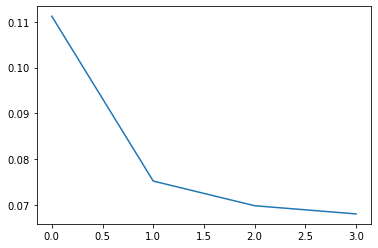

0.11135933228043327 	 0.06703194334122067
Overall Loss: 0.059923444750565574


In [202]:
trainDataSet(1,500,"normal", learn=0.3,norandom=False)

In [ ]:
int(0.2*123)